<img src="https://gitlab.inf.unibz.it/earth_observation_public/eurac-openeo-examples/-/raw/main/python/auxdata/eurac_EO.png"
     alt="EURAC EO logo"
     style="float: left; margin-right: 10px; max-width: 300px" />

<img src="https://avatars.githubusercontent.com/u/63704085?s=400&u=5dc6c45b7d457ce6f303fbc612091cb2c133482f&v=4"
     alt="SAR2Cube logo"
     style="float: right; max-width: 200px" />
## SAR2Cube and openEO - Accessing and Analyzing SAR data on-the-fly
### Author michele.claus@eurac.edu
### Date: 2022/09/29

## Useful links:

SAR2Cube website: https://sar2cube.projects.eurac.edu/

openEO main website: https://openeo.org/

openEO Python Client documentation: https://open-eo.github.io/openeo-python-client/index.html

Getting started guide for openEO with python: https://openeo.org/documentation/1.0/python/

## Topics:
- Login to Eurac's openEO backend containing the SAR2Cube data sets
- Compute the intensity over the area of interest with different Multi Look sizes in SAR and geocoded domain
- Apply the radar mask to remove areas affected by layover, foreshortening or shadow effects

### Import all the libraries and utilities functions included in the eo_utils.py file

Please check to have the latest openeo library. Please check here for the latest available version: https://pypi.org/project/openeo/

In [6]:
import openeo
openeo.__version__

'0.12.0'

In [7]:
from eo_utils import *

### Connect and login

In [8]:
openeoHost = "https://openeo.eurac.edu"
conn = openeo.connect(openeoHost).authenticate_oidc(client_id="openEO_PKCE")

Authenticated using refresh token.


## Select the AOI
Use the rectangle selection tool to select the area of interest

In [9]:
center = [46.6, 11.3]
zoom = 10

eoMap = openeoMap(center,zoom)
eoMap.map

Map(center=[46.6, 11.3], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out…

In [10]:
bbox = eoMap.getBbox()
print("Coordinates selected from map:",'\n west',bbox[0],'\n east',bbox[2],'\n south',bbox[1],'\n north',bbox[3])

Coordinates selected from map: 
 west 11.274719 
 east 11.396942 
 south 46.404786 
 north 46.535311


In [11]:
spatial_extent  = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3]}

# SAR processing


### Load the datacube

In [12]:
conn = openeo.connect(openeoHost).authenticate_oidc(client_id="openEO_PKCE")

collection      = 'SAR2Cube_SInCohMap_S1_L0_117_ASC_SOUTH_TYROL'
temporal_extent = ["2018-06-01T00:00:00.000Z", "2018-06-30T00:00:00.000Z"]

S1_slant_range = conn.load_collection(collection,spatial_extent=spatial_extent,temporal_extent=temporal_extent)

Authenticated using refresh token.


Compute the intensity

In [13]:
i_VV = S1_slant_range.band('i_VV')
q_VV = S1_slant_range.band('q_VV')
S1_INT = (i_VV**2+q_VV**2)
S1_INT_VV = S1_INT.add_dimension(name="bands",label="VV")

Compute the Multi Look over the intensity and convert from linear to dB.

In [14]:
range_looks   = 19
azimuth_looks = 4

In [15]:
args_aggregate_spatial_window = {"data": THIS,
                                 "boundary": "trim",
                                 "size": [range_looks,azimuth_looks],
                                 "reducer":S1_INT_VV._get_callback(mean,parent_parameters=["data"])
                                }

S1_INT_VV_ML = S1_INT_VV.process("aggregate_spatial_window",args_aggregate_spatial_window)

# Linear to dB conversion:
S1_INT_VV_ML = S1_INT_VV_ML.apply(lambda x: 10*log(x,base=10))

Compute the same Multi Look over the coordinate grids for geocoding

In [16]:
lat_lon = S1_slant_range.filter_bands(['grid_lon','grid_lat'])

In [17]:
args_aggregate_spatial_window = {"data": THIS,
                                 "boundary": "trim",
                                 "size": [range_looks,azimuth_looks],
                                 "reducer":lat_lon._get_callback(mean,parent_parameters=["data"])
                                }

lat_lon_ML = lat_lon.process("aggregate_spatial_window",args_aggregate_spatial_window)

Compute the Multi Look of Local Incidence Angle and Digital Elevation Model for radar masking

In [18]:
dem_lia = S1_slant_range.filter_bands(['DEM','LIA'])

In [19]:
args_aggregate_spatial_window = {"data": THIS,
                                 "boundary": "trim",
                                 "size": [range_looks,azimuth_looks],
                                 "reducer":dem_lia._get_callback(mean,parent_parameters=["data"])
                                }

dem_lia_ML = dem_lia.process("aggregate_spatial_window",args_aggregate_spatial_window)

Remove the temporal dimension, not required for radar_mask

In [20]:
dem_lia_ML = dem_lia_ML.reduce_dimension(reducer=mean, dimension='DATE')

Use the **radar_mask** process inside an **apply_dimension** process.

**apply_dimension** is used when we need to apply a process over a specific dimension, similarly to reduce_dimension, but the specified dimension is not reduced/removed. Instead, the number of output dimension labels (i.e. bands) can grow or shrink.

Use the list_processes method and search for radar_mask to get more details on I/O of this process.

In [21]:
conn.list_processes() # Search for radar_mask

[{'engine': '[ODC_DASK]',
  'id': 'dimension_labels',
  'summary': 'Get the dimension labels',
  'description': 'Returns all labels for a dimension in the data cube. The labels have the same order as in the data cube.',
  'parameters': [{'schema': {'subtype': 'raster-cube', 'type': 'object'},
    'name': 'data',
    'description': 'The data cube.'},
   {'schema': {'type': 'string'},
    'name': 'dimension',
    'description': 'The name of the dimension to get the labels for.'}],
  'categories': ['cubes'],
  'returns': {'schema': {'type': 'array',
    'items': {'anyOf': [{'type': 'number'}, {'type': 'string'}]}},
   'description': 'The labels as array.'},
  'exceptions': {}},
 {'engine': '[WCPS, ODC_DASK]',
  'id': 'ln',
  'summary': 'Natural logarithm',
  'description': 'The natural logarithm is the logarithm to the base *e* of the number `x`, which equals to using the *log* process with the base set to *e*. The natural logarithm is the inverse function of taking *e* to the power x.\n\nThe no-data value `null` is passed through.\n\nThe computations follow [IEEE Standard 754](https://ieeexplore.ieee.org/document/8766229) whenever the processing environment supports it. Therefore, `ln(0)` results in ±infinity if the processing environment supports it or otherwise an error is thrown.',
  'parameters': [{'schema': {'type': ['number', 'null']},
    'name': 'x',
    'description': 'A number to compute the natural logarithm for.'}],
  'categories': ['math > exponential & logarithmic'],
  'links': [{'rel': 'about',
    'href': 'http://mathworld.wolfram.com/NaturalLogarithm.html',
    'title': 'Natural logarithm explained by Wolfram MathWorld'},
   {'rel': 'about',
    'href': 'https://ieeexplore.ieee.org/document/8766229',
    'title': 'IEEE Standard 754-2019 for Floating-Point Arithmetic'}],
  'returns': {'schema': {'type': ['number', 'null']},
   'description': 'The computed natural logarithm.'},
  'exceptions': {},
  'examples': [{'arguments': {'x': 1}, 'returns': 0}]},
 {'engine': '[ODC_DASK]',
  'id': 'coherence',
  'summary': 'Compute the complex coherence with SAR data',
  'description': 'Compute the complex coherence with SAR data, given the specified time delta.',
  'parameters': [{'schema': {'subtype': 'raster-cube', 'type': 'object'},
    'name': 'data',
    'description': 'A raster data cube with exactly two horizontal spatial dimensions and an arbitrary number of additional dimensions. The process is applied to all additional dimensions individually.'},
   {'schema': {'type': 'integer',
     'enum': [6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96]},
    'default': '6',
    'name': 'timedelta',
    'description': 'Temporal delta in days between acquisitions on which we want to compute coherence.',
    'optional': True}],
  'categories': ['cubes', 'math'],
  'returns': {'schema': {'subtype': 'raster-cube', 'type': 'object'},
   'description': 'A data cube with the projected values in the requested projection.'},
  'exceptions': {}},
 {'engine': '[WCPS]',
  'id': 'cos',
  'summary': 'Cosine',
  'description': 'Computes the cosine of `x`.\n\nWorks on radians only.\nThe no-data value `null` is passed through and therefore gets propagated.',
  'parameters': [{'schema': {'type': ['number', 'null']},
    'name': 'x',
    'description': 'An angle in radians.'}],
  'categories': ['math > trigonometric'],
  'links': [{'rel': 'about',
    'href': 'http://mathworld.wolfram.com/Cosine.html',
    'title': 'Cosine explained by Wolfram MathWorld'}],
  'returns': {'schema': {'type': ['number', 'null']},
   'description': 'The computed cosine of `x`.'},
  'exceptions': {},
  'examples': [{'arguments': {'x': 0}, 'returns': 1}]},
 {'engine': '[WCPS, ODC_DASK]',
  'id': 'lt',
  'summary': 'Less than comparison',
  'description': 'Compares whether `x` is strictly less than `y`.\n\n**Remarks:**\n\n* If any operand is `null`, the return value is `null`.\n* If any operand is an array or object, the return value is `false`.\n* If any

In [22]:
radar_mask_node = PGNode('radar_mask', data={'from_parameter': 'data'}, orbit_direction='ASC',foreshortening_th=0.1,layover_th=2.1)
radar_mask = dem_lia_ML.apply_dimension(process=radar_mask_node, dimension="bands")

Rename the output bands with a meaningful name

In [23]:
radar_mask = radar_mask.rename_labels(target=['layover','foreshortening','shadow'],dimension='bands')

Merge the intensity and the coordinates into the same datacube

In [24]:
S1_INT_VV_ML = S1_INT_VV_ML.merge_cubes(lat_lon_ML)

Compute the average over time

In [25]:
S1_INT_ML_VV_MEAN = S1_INT_VV_ML.reduce_dimension(reducer=mean, dimension='DATE')

Merge also the radar_mask output

In [26]:
S1_INT_ML_VV_MEAN = S1_INT_ML_VV_MEAN.merge_cubes(radar_mask)

Geocode the resulting data. We choose 60m resolution for the pixel size and the local UTM zone as projection.

We can choose only from 10, 20 or 60m for resolution, for being able to align the data with Sentinel-2 grid.

In [27]:
args_geocoding = {'resolution':20,'crs':32632}
S1_INT_ML_VV_GEOCODED = S1_INT_ML_VV_MEAN.process("geocode",args_geocoding, data=S1_INT_ML_VV_MEAN)

In [28]:
S1_INT_ML_VV_GEOCODED_NC = S1_INT_ML_VV_GEOCODED.save_result(format='netCDF')

For jobs requiring to process many dates and a big area in the spatial domain, we need to use batch jobs.

The job will run in the background and when it will be marked as finished you can download the result.

In [29]:
job = conn.create_job(S1_INT_ML_VV_GEOCODED_NC,title="SAR2Cube_South_Tyrol_radar_mask_ASC")
job_id = job.job_id
if job_id:
    print("Batch job created with id: ",job_id)
    job.start_job()
else:
    print("Error! Job ID is None")

Batch job created with id:  9c618d35-b9e2-479b-a300-09ab47463b48


In [30]:
job_id

'9c618d35-b9e2-479b-a300-09ab47463b48'

In [31]:
job = conn.job(job_id)

In [34]:
job

<BatchJob job_id='9c618d35-b9e2-479b-a300-09ab47463b48'>

Once the job is marked as finished, you can download the result.

Either via the download link provided in the following visualization:

In [35]:
result = job.get_results()
result

<JobResults for job '9c618d35-b9e2-479b-a300-09ab47463b48'>

Or via python code specifying the target location:

In [36]:
result.download_files("./radar_mask_ASC/")

[PosixPath('radar_mask_ASC/process.json'),
 PosixPath('radar_mask_ASC/result.nc'),
 PosixPath('radar_mask_ASC/job-results.json')]

In [37]:
out = xr.open_dataarray("./radar_mask_ASC/result.nc").to_dataset(dim='variable')
out

<xarray.Dataset>
Dimensions:         (y: 739, x: 491)
Coordinates:
  * y               (y) float32 5.142e+06 5.142e+06 ... 5.156e+06 5.156e+06
  * x               (x) float32 6.744e+05 6.744e+05 ... 6.842e+05 6.842e+05
Data variables:
    VV              (y, x) float32 ...
    foreshortening  (y, x) float32 ...
    layover         (y, x) float32 ...
    shadow          (y, x) float32 ...

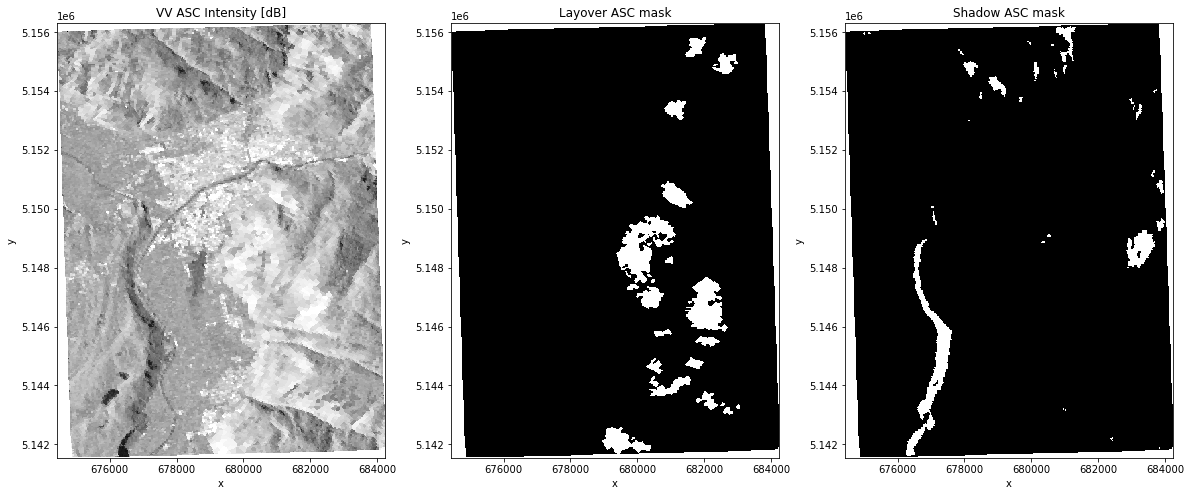

In [44]:
plot_args = {'cmap':'Greys_r','add_colorbar':False}
fig, ax = plt.subplots(1,3,figsize=(20,8))
out.VV.plot.imshow(ax=ax[0],**plot_args, vmin=-30,vmax=0)
ax[0].set_title("VV ASC Intensity [dB]")
out.layover.plot.imshow(ax=ax[1],**plot_args, vmin=0,vmax=1)
ax[1].set_title("Layover ASC mask")
out.shadow.plot.imshow(ax=ax[2],**plot_args, vmin=0,vmax=1)
ax[2].set_title("Shadow ASC mask")
plt.show()